# Graph Building using networkx
A network analysis of the authorship networks in the top 5 economic journals from 1940 to 2020 replicating the methodology in “Economics: An Emerging Small World.” (Goyal, Van der Leij and Moraga-Gonzalez , 2006). Their paper examines the evolution of social distance using network analysis to show that it has become easier to maintain and form distant ties amongst economists because of technological developments in travel and communication, at least over the 1970 - 2020 period. 

Note that our metadata contains author name and publication data dating back to the first publication of each journal, these being American Economic Review (), Econometrica (), Journal of political economy(), Review of economic studies() and Quarterly Journal of Economics(). The earliest article occurs in 1884. Although I will only be examining the period 1940 to 2020, this notebook still builds all networks within the period 1881 to 2020 where each network is built with coauthor data of articles from every 10-year interval ie: 1881-1890, 1891-1900, 1901-1910 ... 2011-2020. 

### Notes:

Each author is a node and each link between two authors indicates they have coauthored at least one article in the top 5 economic journals. If A and B are linked, they have a distance of 1. If C is directly linked to B but not A, then A and C are said to have a distance of 2. All authors who are either directly or indirectly linked with each other are said to belong to the same component, the largest set of interconnected authors is called the giant component if it consitutes a large percentage of nodes and the other components are relatively small. A larger relative size of the giant component and a shorter average distance between economists in the giant component is evidence that the world is becoming smaller.

Definitions from Goyal et al.:

**Degree**: the number of coathors an author has in a network.

**Giant component**: Two persons belong to the same component if and only if there exists a path between them. A component is a giant component if the largest component constitutes a relatively large part of the population of economists and all other components are small.

**Distance**: the shortest path between two authors. The distance is infinity if the authors if a path does not exist between two authors.

**Clustering**: The clustering coefficient of a network is a measure of the overlap between the links of different authors. This ratio tells us the percentage of a′person’s coauthors who are coauthors of each other.

A network exhibits **small world** properties if: 
1. number of nodes is very large compared to the average number of coauthors. number of nodes>> average degree
2. the network is integrated; a giant component exists and covers a large share of the population
3. the average distance between nodes in the giant component is small: ie: the average distance is of order ln(n).
4. clustering is high such that the clustering coefficient is much larger than the average number of coauthors, CC >> average degree

Assumptions: affiliations resolved author name clashes in previous stage. 

Goyal, Sanjeev, Marco J. van der Leij, and José Luis Moraga‐González. “Economics: An Emerging Small World.” Journal of Political Economy 114, no. 2 (2006): 403–12. https://doi.org/10.1086/500990.

Disclaimer: copied and pasted most of this from Goyal et al..

In [25]:
import networkx as nx
import json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
import numpy as np


In [26]:
base_path="/Users/sijiawu/Work/Thesis/Data/Affiliations/"

Load in author data. Assume this has already been fixed

In [27]:
with open(base_path+"author_proc_all_w_red.json") as f: 
    data = f.read() 
proc_auths_all = json.loads(data) 

proc_auths=pd.read_pickle(base_path+"auth_proc_w_aff_flat.pkl")
j_data=pd.read_pickle(base_path.split('Aff')[0]+"Combined/022_merged_proc_scopus_inception_with_auth_split_2020_content_type_corrected.pkl")

In [28]:
sum(j_data[j_data['type']=="S"]['author_count'])/j_data[j_data['type']=="S"].shape[0]

1.3786013297217434

In [29]:
j_data[(j_data['author'].str.lower().str.contains('frederick c. mills')==True)& (j_data["content_type"]!='MISC')& (j_data["content_type"]!='Review')][['content_type','author','year','title','URL','type']]

,content_type,author,year,title,URL,type
17216,Article,Frederick C. Mills,1952,the role of productivity in economic growth,https://www.jstor.org/stable/1910627,S
18023,Article,Frederick C. Mills,1949,"wesley clair mitchell, 1874-1948",https://www.jstor.org/stable/1809329,N
18068,Article,Frederick C. Mills,1949,opening remarks,https://www.jstor.org/stable/1831729,S
18626,Article,Frederick C. Mills,1947,the economic outlook of friday and edie and ayres,https://www.jstor.org/stable/1821111,S
18952,Article,Eveline M. Burns and Joseph J. Spengler and Ed...,1946,the proposed publication of a periodic review ...,https://www.jstor.org/stable/1818245,S
19473,Article,James Washington Bell and Frank A. Fetter and ...,1944,what should be the relative spheres of private...,https://www.jstor.org/stable/1818702,S
20317,Article,Frederick C. Mills,1941,economics in a time of change,https://www.jstor.org/stable/1804225,N
21802,Discussion,Frederick C. Mills and Frank G. Dickinson and ...,1936,relation of size of plants to prices: discussion,https://www.jstor.org/stable/1807764,S
23319,Article,Frank W. Taussig and Frederick C. Mills and F....,1930,the theory of economic dynamics as related to ...,https://www.jstor.org/stable/1805658,S
23735,Article,Frederick C. Mills and Jacob H. Hollander and ...,1928,the present status and future prospects of qua...,https://www.jstor.org/stable/1811547,S


In [30]:
proc_auths_all["https://www.jstor.org/stable/1910627"]["authors"]["0"]["resolution"]

'frederick c. mills'

Function for building a graph.

In [31]:
# function purpose: takes a start year, an end year and builds the network of authors between these years given the type of names "a1", "a2" etc.
# this function assumes the availability of a global proc_auths_all dictionary containing author names from the previous data cleaning stage. 
# start_year is the first year in which athurs enter the network
# end_year is the first year where authors are no longer part of this network
# al_class specifies the type of author name variation to use to build the network
# restrict excludes articles of the specified article types from the network.
def build_graph(start_year, end_year, al_class, restrict={"Article":0, "Review":0, "MISC":0, "Comment":0, "Reply":0, "Review2":0, "Discussion":0, "Rejoinder":0}):
    a=0
    b=[]
    c=[]
    content_type=[]
    years=2021
    G = nx.Graph()
    alias_all=[]
    for i in proc_auths_all.keys():
#         a=a+1
#         if a>1000:
#             break
        alias=[]
        entry=proc_auths_all[i]["authors"]
        years=min(years, proc_auths_all[i]["year"])
        # content_type.append(proc_auths_all[i]["content_type"])
        if restrict[proc_auths_all[i]["content_type"]]==1:
            continue
        if (proc_auths_all[i]["year"]<start_year) or (proc_auths_all[i]["year"]>=end_year):
            continue
        for j in range(len(entry.keys())):
            alias.append(entry[str(j)][al_class])
            alias_all.append(entry[str(j)][al_class])
        combinations = list(itertools.combinations(alias, 2))

        for l in alias:
            if G.has_node(l):
                n_count=len(G.nodes[l]["year"])
                G.nodes[l]["year"][n_count]=proc_auths_all[i]["year"]
                G.nodes[l]["weight"] = G.nodes[l]["weight"]+1
                if len(alias)>1:
                    G.nodes[l]["collab"]=G.nodes[l]["collab"]+1
            else:
                G.add_node(l, year={0: proc_auths_all[i]["year"]})
                G.nodes[l]["weight"] = 1
                if len(alias)==1:
                    G.nodes[l]["collab"]=0
                else:
                    G.nodes[l]["collab"]=1


        for k in combinations:
            if G.has_edge(*k):
                # we added this one before, just increase the weight by one
                G[k[0]][k[1]]['weight'] += 1
                e_count=len(G[k[0]][k[1]]['year'])
                G[k[0]][k[1]]['year'][e_count]=proc_auths_all[i]["year"]
            else:
                # new edge. add with weight=1
                G.add_edge(*k, weight=1, year={0:proc_auths_all[i]["year"]})
#     G=nx.convert_node_labels_to_integers(G, first_label=0, ordering='sorted', label_attribute="auth_name")
    # print(pd.DataFrame(content_type).value_counts())
    return [G, alias_all, years, b]


A function for computing average shortest path and standard deviation of shortest path within a connected component

In [32]:
# pairs: a list of tuple pairs
# pairs_dict: dictionary where tuple pairs resolve to a int or float
def pop_stats(pairs, pair_dict):
    sp=0
    ss=0
    x=[]
    n=len(pairs)
    print(n)
    if n<=1:
        return [None, None, x]
    for i in pairs:
        sp+=pair_dict[i[0]][i[1]]
        x.append(pair_dict[i[0]][i[1]])
        ss+=(pair_dict[i[0]][i[1]]**2)
    x_bar=sp/n
    s_squared=(ss-n*(x_bar**2))/(n-1)
    return [x_bar, s_squared**0.5, x]

Using the function above and network x, this function compiles the statistics for a network.

In [86]:
# G is a graph
def calc_network_stats(G):
    rd=3
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    gcc_count=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    G0 = G.subgraph(Gcc[0])
    G1 = G.subgraph(Gcc[1])
    G2 = G.subgraph(Gcc[2])
    
    degree_sequence = np.array(sorted((d for n, d in G.degree()), reverse=True))
    # print(np.array(degree_sequence))
    avg_deg=sum(degree_sequence)/G.number_of_nodes()
    deg_std=math.sqrt(sum((degree_sequence-avg_deg)**2)/(G.number_of_nodes()-1))
    isol=sum(degree_sequence==0)
    print("calculating shortest path stats")
    stime=time.time()
    
    p = dict(nx.shortest_path_length(G0))
    combinations = list(itertools.combinations(list(G0), 2))
    sp_stats=pop_stats(combinations, p)
    # plt.hist(sp_stats[2])
    # plt.show()
    print('creating random refs')
    
    K=nx.random_reference(G, niter=2)
    degree_sequence_=np.array(sorted((d for n, d in K.degree()), reverse=True))
    avg_deg_=sum(degree_sequence_)/K.number_of_nodes()
    deg_std_=math.sqrt(sum((degree_sequence_-avg_deg_)**2)/(K.number_of_nodes()-1))

    K2=nx.erdos_renyi_graph(G.number_of_nodes(), avg_deg/G.number_of_nodes())
    degree_sequence_2=np.array(sorted((d for n, d in K2.degree()), reverse=True))
    avg_deg_2=sum(degree_sequence_2)/K2.number_of_nodes()
    deg_std_2=math.sqrt(sum((degree_sequence_2-avg_deg_2)**2)/(K2.number_of_nodes()-1))



    p1 = dict(nx.shortest_path_length(G1))
    combinations = list(itertools.combinations(list(G1), 2))
    sp_stats1=pop_stats(combinations, p1)

    
    p2 = dict(nx.shortest_path_length(G2))
    combinations = list(itertools.combinations(list(G2), 2))
    sp_stats2=pop_stats(combinations, p2)

    
    etime=time.time()    
    print("path stat calc complete " +str(etime-stime))
    
    return {
        "Number of nodes": G.number_of_nodes(),
        "Number of edges":G.number_of_edges(),
        "Number of CC": nx.number_connected_components(G),
        "LCC": len(G0),
        "LCC %": round(len(G0)*100/G.number_of_nodes(), rd),
        "2nd LCC": len(G1),
        "2nd LCC %": round(len(G1)*100/G.number_of_nodes(), rd),
        "3rd LCC": len(G2),
        "3rd LCC %": round(len(G2)*100/G.number_of_nodes(), rd),
        "AVG clustering": round(nx.average_clustering(G), max(rd, 5)),
        "AVG clustering rnd": round(nx.average_clustering(K), max(rd, 5)),
        "AVG clustering ER": round(nx.average_clustering(K2), max(rd, 5)),
        "AVG clustering weighted":nx.average_clustering(G, weight='weight'),
        "AVG clustering deg>1":nx.average_clustering(G, nodes=[n for n in G if G.degree(n) > 1]),
        "AVG clustering rnd deg>1": round(nx.average_clustering(K, nodes=[n for n in K if K.degree(n) > 1]), max(rd, 5)),
        "AVG clustering ER deg>1": round(nx.average_clustering(K2, nodes=[n for n in K2 if K2.degree(n) > 1]), max(rd, 5)),
        "AVG clustering weighted deg>1 ":nx.average_clustering(G, weight='weight',nodes=[n for n in G if G.degree(n) > 1]),
        "transitivity":round(nx.transitivity(K), max(rd, 5)),
        "centers of LCC":list(nx.center(G0)),
        "AVG degree": round(avg_deg, max(rd,5)),
        "degree std": round(deg_std, max(rd,5)),
        "degree std rnd": round(deg_std_, max(rd,5)),
        "degree std ER": round(deg_std_2, max(rd,5)),
        "isolated authors": isol,
        "isolated authors %":round(isol*100/G.number_of_nodes(), rd),
        "LCC avg shortest path": sp_stats[0] if sp_stats[0] is None else round(sp_stats[0], max(rd,5)),
        "LCC std shortest path": sp_stats[1] if sp_stats[1] is None else round(sp_stats[1], max(rd,5)), 
        "2nd LCC avg shortest path": sp_stats1[0] if sp_stats1[0] is None else round(sp_stats1[0], max(rd,5)),
        "2nd LCC std shortest path": sp_stats1[1] if sp_stats1[1] is None else round(sp_stats1[1], max(rd,5)),
        "3rd LCC avg shortest path": sp_stats2[0] if sp_stats2[0] is None else round(sp_stats2[0], max(rd,5)),
        "3rd LCC std shortest path": sp_stats2[1] if sp_stats2[1] is None else round(sp_stats2[1], max(rd,5))
    }


def calc_auth_stat(G, node):
    """
    Compute various statistics for a given node in a network.
    
    Parameters:
    G (networkx.Graph): The graph
    node (int or str): The node ID

    Returns:
    dict: A dictionary of computed statistics
    """
    stats = {}

    # 1. Weight of the node (assuming weight is an attribute)
    stats["papers"] = G.nodes[node].get("weight", 1)  # Default weight = 1 if not present

    # 2. Node attribute "collab"
    stats["collab"] = G.nodes[node].get("collab", 0)  # Default collab = 0 if not present

    # 3. Percentage ratio of collab/weight
    stats["collab_ratio"] = (stats["collab"] / stats["papers"]) if stats["papers"] != 0 else 0

    # 4. Degree of the node
    stats["degree"] = G.degree[node]

    # 5. Number of nodes at a distance of 2
    two_hop_neighbors = set()
    for neighbor in G.neighbors(node):  # First-degree neighbors
        two_hop_neighbors.update(G.neighbors(neighbor))  # Second-degree neighbors
    two_hop_neighbors.discard(node)  # Remove the node itself
    stats["nodes_at_distance_2"] = len(two_hop_neighbors)

    # 6. Clustering coefficient of the node
    stats["clustering_coefficient"] = nx.clustering(G, node)

    return stats

def average_top_node_statistics(G, amt=100):
    """ Compute average statistics for the top 100 nodes ranked by degree """
    node_dict = dict(G.degree())
    proc_nodes=node_dict.items()
    if amt!=-1:
        proc_nodes = sorted(node_dict.items(), key=lambda x: x[1], reverse=True)[:amt]

    stats_list = [calc_auth_stat(G, node) for node, _ in proc_nodes]
    
    avg_stats = {
        key: np.mean([stat[key] for stat in stats_list]) for key in stats_list[0]
    }

    return avg_stats

def calc_stats_stars(G):
    star_stats={}
    degree_dict = dict(G.degree())
    nodes_by_deg=sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    top_5_nodes = nodes_by_deg[:5]
    i=1
    for node, degree in top_5_nodes:
        # print(f"Node {node}: Degree {degree}")
        star_stats["top "+str(i)]=calc_auth_stat(G,node)
        star_stats["top "+str(i)]["rank"]=i
        star_stats["top "+str(i)]["Node"]=node
        i+=1
    star_stats["avg_10"]=average_top_node_statistics(G, 10)
    star_stats["avg_10"]['rank']=i
    star_stats["avg_10"]["Node"]="avg_10"
    i+=1
    star_stats["avg_100"]=average_top_node_statistics(G, 100)
    star_stats["avg_100"]['rank']=i
    star_stats["avg_100"]["Node"]="avg_100"
    i+=1
    star_stats["avg_all"]=average_top_node_statistics(G, -1)
    star_stats["avg_all"]['rank']=i
    star_stats["avg_all"]["Node"]="avg_all"

    return star_stats


def plot_rank_as_category(df, value_column):
    plt.figure(figsize=(12, 6))

    # Get unique ranks
    unique_ranks = df["rank"].unique()

    # Plot each rank's value over time
    for rank in unique_ranks:
        rank_data = df[df["rank"] == rank]
        plt.plot(rank_data["start"], rank_data[value_column], marker="o", linestyle="-", label=list(set(rank_data['rank_cat']))[0], alpha=0.7)

    plt.xlabel("Start Year")
    plt.ylabel(value_column.replace("_", " ").title())  # Format label
    plt.title(f"{value_column.replace('_', ' ').title()} Progression Over Time")
    plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

def plot_rank_as_stacked_chart(df, value_column, chart_type="bar", bar_order=False):
    """
    Plots a stacked line or bar chart where each rank category contributes cumulatively over time.

    Parameters:
    df (pd.DataFrame): Dataframe containing 'rank', 'start' (year), and a numerical value column.
    value_column (str): The column to plot as Y-axis (e.g., 'degree', 'collab', etc.).
    chart_type (str): "bar" for stacked bar chart, "line" for stacked line chart.
    """
    plt.figure(figsize=(12, 6))

    # Pivot data to get a stacked format (years as index, rank categories as columns)
    df_pivot = df.pivot_table(index="start", columns="rank_cat", values=value_column, aggfunc="sum").fillna(0)
    df_labels = df.pivot_table(index="start", columns="rank_cat", values="Node", aggfunc="first").fillna("")


    if bar_order and chart_type == "bar":
        df_pivot = df_pivot[bar_order]
    # Plot stacked bar chart

 

    if chart_type == "bar":
        ax=plt.gca()
        bars = df_pivot.plot(kind="bar", stacked=False, colormap="Set2", alpha=0.8, width=0.8, ax=ax)
        y_max = ax.get_ylim()[1]
        y_mid = y_max / 2
        print(y_max)
        print(y_mid)
        # for container in bars.containers:
        #     ax.bar_label(container, fmt="%.1f", fontsize=8, padding=-3, rotation=90)

        for i, container in enumerate(bars.containers):
            for j, bar in enumerate(container):
                height = bar.get_height()
                if height > 0:  # Avoid labeling zero-height bars
                    label_value = df_labels.iloc[j, i].replace("avg_","").upper()  # Get corresponding label from the same row
                    ax.text(bar.get_x() + bar.get_width() / 2, y_mid/2, 
                            f"{height:.3f}", ha="center", va="bottom", fontsize=10, rotation=90, color='black')
                    ax.text(bar.get_x() + bar.get_width() / 2, y_max/6, 
                            f"{label_value}", ha="center", va="bottom", fontsize=10, color='black')
                    
    # Plot stacked line chart
    elif chart_type == "line":
        df_pivot.plot(kind="line", stacked=True, colormap="Set2", alpha=0.85, linewidth=2, ax=plt.gca())
    
    plt.xticks(rotation=0)
    plt.xlabel("Start Year")
    plt.ylabel(value_column.replace("_", " ").title())  # Format label
    plt.title(f"Stacked {value_column.replace('_', ' ').title()} Progression Over Time")
    plt.legend(title="Category", loc="best", fontsize="small", bbox_to_anchor=(1, 1))
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.1)
    plt.show()

def plot_filtered_clustering_vs_degree(G, start, end):
    """
    Plots the clustering coefficient versus degree for nodes in a given NetworkX graph G,
    only including nodes with a degree of at least 2.
    """
    # Compute degree and clustering coefficient for each node
    degrees = dict(G.degree())
    clustering_coeffs = nx.clustering(G)
    
    # Filter nodes with degree >= 2
    filtered_degrees = [deg for node, deg in degrees.items() if deg >= 2]
    filtered_clustering = [clustering_coeffs[node] for node, deg in degrees.items() if deg >= 2]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_degrees, filtered_clustering, alpha=0.1, color="red", edgecolors="black")
    plt.xlabel("Degree")
    plt.ylabel("Clustering Coefficient")
    plt.title("Clustering Coefficient vs. Degree for "+str(start)+ ' - '+str(end))
    plt.grid(True)
    plt.show()


from collections import Counter

def plot_aggregated_clustering_vs_degree(G, radius=0.025):
    """
    Plots the clustering coefficient versus degree for nodes in a given NetworkX graph G,
    only including nodes with a degree of at least 2, and aggregates points within a given radius.
    The size of each point represents the number of nodes with the same (degree, clustering coefficient) combination.
    """
    # Compute degree and clustering coefficient for each node
    degrees = dict(G.degree())
    clustering_coeffs = nx.clustering(G)
    
    # Filter nodes with degree >= 2
    filtered_data = [(deg, clustering_coeffs[node]) for node, deg in degrees.items() if deg >= 2]

    # Round values to avoid excessive overlap (group similar points)
    rounded_data = [(round(deg, 1), round(coeff, int(-np.log10(radius)))) for deg, coeff in filtered_data]

    # Count occurrences of each unique (degree, clustering coefficient) pair
    count_data = Counter(rounded_data)

    # Extract values for plotting
    x_values, y_values, sizes = zip(*[(deg, coeff, count * 50) for (deg, coeff), count in count_data.items()])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, s=sizes, alpha=0.7, color="red", edgecolors="black")
    plt.xlabel("Degree")
    plt.ylabel("Clustering Coefficient")
    plt.title("Aggregated Clustering Coefficient vs. Degree (Filtered: Degree ≥ 2)")
    plt.grid(True)
    plt.show()



In [87]:
j_data.content_type.unique()

array(['Article', 'MISC', 'Comment', 'Reply', 'Errata', 'Rejoinder',
       'Discussion', 'Review', 'Correction', 'Review2'], dtype=object)

In [69]:
# output=build_graph(1800, 2021, "a1", {"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":0, "Rejoinder":0})
output=build_graph(1940, 2021, "resolution", {"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0,"Errata":1})
L=output[0]
# nx.write_gexf(L, "authnetwork_1940_2021_a1.gexf")

Gcc = sorted(nx.connected_components(L), key=len, reverse=True)
L0=L.subgraph(Gcc[0])
L.number_of_nodes()
# calc_network_stats(L)
pd.DataFrame(calc_stats_stars(L)).transpose().reset_index().rename(columns={"index": "rank_cat"}).to_csv("full_stars_1940_2020_a1.csv")
# pd.DataFrame(calc_network_stats(L)).transpose().to_csv("full_net_1940_2020_a1.csv")

nx.write_gexf(output[0], "network_r_1940_2020.gexf")

#check if maths is wrong for avg 100, there is some sort of double counting for collab ratios becuase it's doing a weighted average which may be weird

Testing the functions with the full set, ie: all authors of all time.

Build each 10-year network of authors from 1881 to 2021.

In [ ]:
networks={}
j=0
data=[]
for i in range(1940,2021,10):
    if (i+10)>2021:
        break
    print("network for period: "+str(i)+ " to "+ str(i+10))
    content_restrict={"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0, "Errata":1}
    output=build_graph(i, i+10, "resolution", content_restrict)

    # op=calc_network_stats(output[0])
    op=calc_stats_stars(output[0])
    # op["start"]=i
    # op['end']=i+10
    temp_df=pd.DataFrame(op).transpose().reset_index().rename(columns={"index": "rank_cat"})
    temp_df['start']=i
    temp_df['end']=i+10
    data.append(temp_df)
    networks[j]={"graph":output[0], "start":i, "end": i+10}
    nx.write_gexf(output[0], "network_r_"+str(i)+"_"+str(i+10)+".gexf")
    plot_filtered_clustering_vs_degree(output[0], i, i+10)
    plot_aggregated_clustering_vs_degree(output[0])



In [71]:
df=pd.concat(data)
# df.to_excel("rolling_10Y_network_stars.xlsx")    
# df.transpose().to_excel("rolling_10Y_network_stars_trans.xlsx")    
# df.transpose().to_csv("rolling_10Y_network_stars_trans.csv")    

# pd.set_option('max_colwidth', None)
# pd.set_option('display.max_columns', None)

In [72]:

for i in range(1940,2020,10):
    df[df['start']==i].to_csv("stars_"+str(i)+"_"+str(i+10)+".csv", index=False)

In [73]:
list(df['rank_cat'].unique())

['top 1', 'top 2', 'top 3', 'top 4', 'top 5', 'avg_10', 'avg_100', 'avg_all']

19.32
9.66


/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_99102/1692793981.py:194: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot = df.pivot_table(index="start", columns="rank_cat", values=value_column, aggfunc="sum").fillna(0)


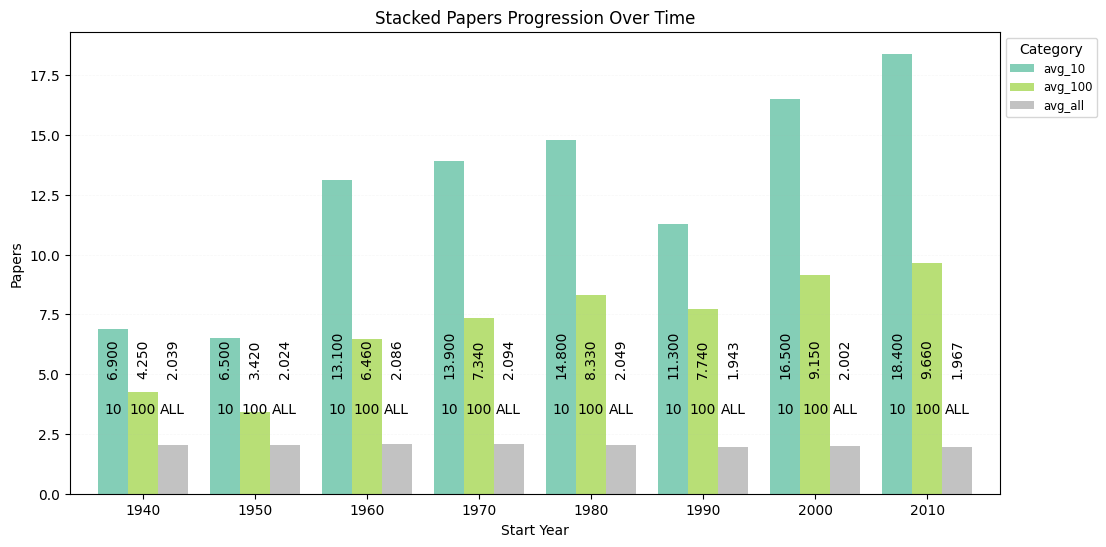

/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_99102/1692793981.py:194: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot = df.pivot_table(index="start", columns="rank_cat", values=value_column, aggfunc="sum").fillna(0)


18.585
9.2925


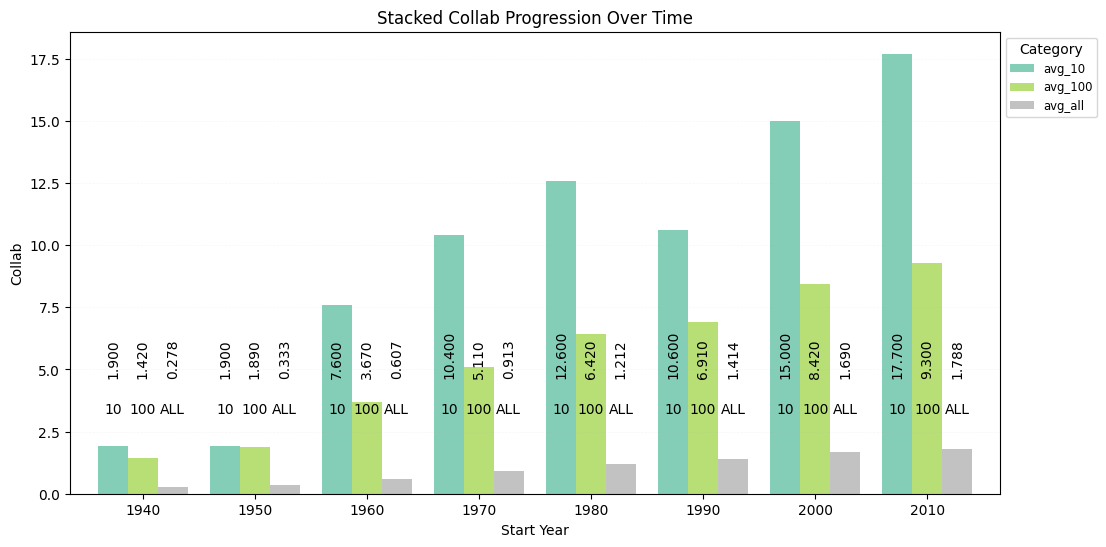

1.0143947368421053
0.5071973684210527


/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_99102/1692793981.py:194: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot = df.pivot_table(index="start", columns="rank_cat", values=value_column, aggfunc="sum").fillna(0)


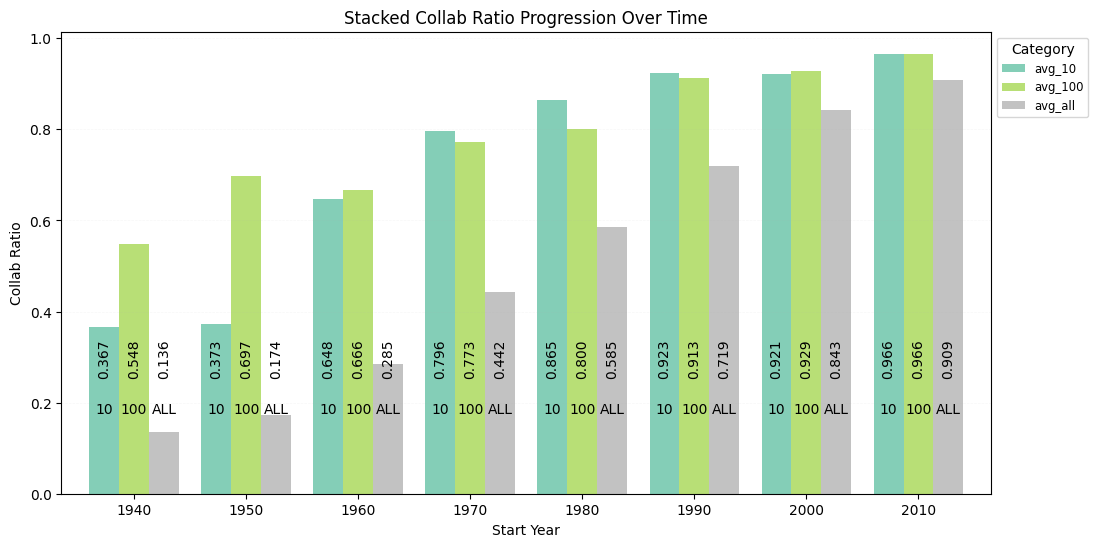

/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_99102/1692793981.py:194: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot = df.pivot_table(index="start", columns="rank_cat", values=value_column, aggfunc="sum").fillna(0)


31.5
15.75


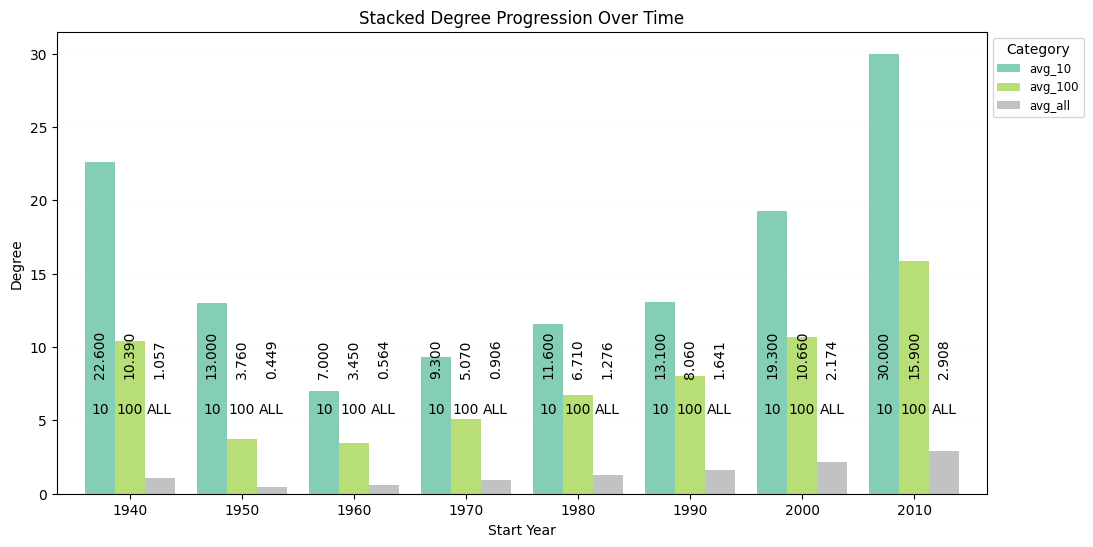

/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_99102/1692793981.py:194: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot = df.pivot_table(index="start", columns="rank_cat", values=value_column, aggfunc="sum").fillna(0)


142.275
71.1375


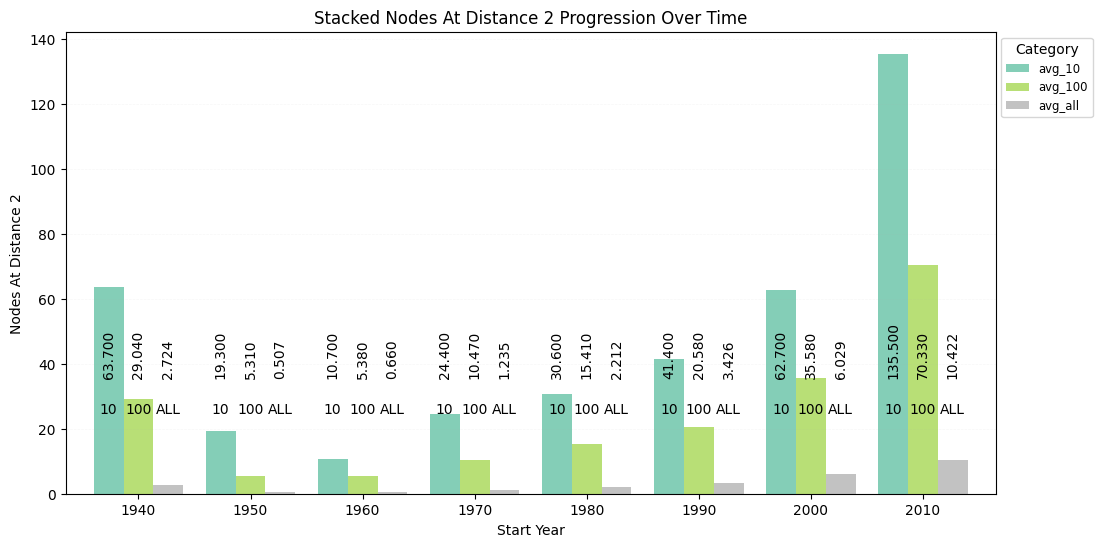

0.9424343891402714
0.4712171945701357


/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_99102/1692793981.py:194: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot = df.pivot_table(index="start", columns="rank_cat", values=value_column, aggfunc="sum").fillna(0)


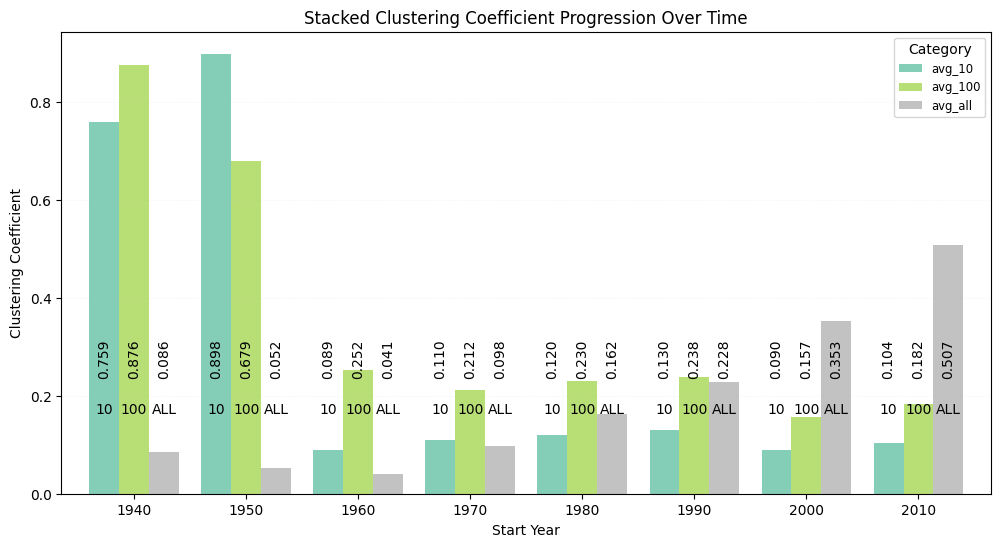

In [ ]:
for i in ['papers', 'collab', 'collab_ratio', 'degree', 'nodes_at_distance_2',
       'clustering_coefficient']:
    # plot_rank_as_category(df, i)
    # plot_rank_as_grouped_or_stacked_chart_with_midway_labels(df, i, chart_type="bar", bar_order=['top 1', 'top 2', 'top 3', 'top 4', 'top 5', 'avg_10', 'avg_100', 'avg_all'])
    plot_rank_as_stacked_chart(df, i, chart_type="bar", bar_order=['avg_10', 'avg_100', 'avg_all'])


In [75]:
df.to_csv("stars_1940_2020.csv", index=False)

In [76]:
# df=pd.DataFrame(data)
# df.to_excel("rolling_10Y_network_summary.xlsx", index=False)    
# df.transpose().to_excel("rolling_10Y_network_summary_trans.xlsx")    
# df.transpose().to_csv("rolling_10Y_network_summary_trans.csv")    

# pd.set_option('max_colwidth', None)
# pd.set_option('display.max_columns', None)



In [77]:
# contractions=pd.DataFrame(proc_auths[proc_auths['a1'].str[0:2].str.contains('\.')].value_counts(["year","journal"]))


In [20]:
networks_20={}
j=0
data_20=[]
for i in range(1940,2021,20):
    if (i+20)>2021:
        break
    print("network for period: "+str(i)+ " to "+ str(i+20))
    content_restrict={"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0, "Errata":1}
    output=build_graph(i, i+20, "resolution", content_restrict)
    networks_20[j]={"graph":output[0], "start":i, "end": i+20}
    op=calc_network_stats(output[0])
    op["start"]=i
    op['end']=i+20
    data_20.append(op)
    nx.write_gexf(output[0], "network_r_"+str(i)+"_"+str(i+20)+".gexf")



network for period: 1940 to 1960
calculating shortest path stats
6786
creating random refs
210
190
path stat calc complete 0.1974191665649414
network for period: 1960 to 1980
calculating shortest path stats
204480
creating random refs
276
190
path stat calc complete 1.5107231140136719
network for period: 1980 to 2000
calculating shortest path stats
2075703
creating random refs
351
66
path stat calc complete 561.3671238422394
network for period: 2000 to 2020
calculating shortest path stats
10734661
creating random refs
190
120
path stat calc complete 2091.745640039444


In [ ]:
# df_20=pd.DataFrame(data_20)
# df_20.to_excel("rolling_20Y_network_summary.xlsx", index=False)    
# df_20.transpose().to_excel("rolling_20Y_network_summary_trans.xlsx")    
# df_20.transpose().to_csv("rolling_20Y_network_summary_trans.csv")    

# pd.set_option('max_colwidth', None)
# pd.set_option('display.max_columns', None)

In [ ]:
df

,rank_cat,papers,collab,collab_ratio,degree,nodes_at_distance_2,clustering_coefficient,rank,Node,start,end
0,top 1,6,2,0.333333,32,64,0.493952,1,frederick c. mills,1940,1950
1,top 2,10,2,0.2,28,65,0.52381,2,fritz machlup,1940,1950
2,top 3,3,2,0.666667,27,69,0.538462,3,aryness j. wickens,1940,1950
3,top 4,3,3,1.0,25,63,0.546667,4,edward s. mason,1940,1950
4,top 5,7,2,0.285714,22,63,0.692641,5,albert b. wolfe,1940,1950
...,...,...,...,...,...,...,...,...,...,...,...
3,top 4,19,19,1.0,31,118,0.092473,4,emmanuel saez,2010,2020
4,top 5,13,13,1.0,30,104,0.11954,5,sendhil mullainathan,2010,2020
5,avg_10,18.4,17.7,0.96609,30.0,135.5,0.104208,6,avg_10,2010,2020
6,avg_100,9.66,9.3,0.965679,15.9,70.33,0.182388,7,avg_100,2010,2020


In [22]:
networks_20_10={}
j=0
data_20_10=[]
for i in range(1940,2021,10):
    if (i+20)>2021:
        break
    print("network for period: "+str(i)+ " to "+ str(i+20))
    content_restrict={"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0, "Errata":1}
    output=build_graph(i, i+20, "resolution", content_restrict)
    networks_20_10[j]={"graph":output[0], "start":i, "end": i+20}
    op=calc_network_stats(output[0])
    op["start"]=i
    op['end']=i+20
    data_20_10.append(op)
    nx.write_gexf(output[0], "network_r_"+str(i)+"_"+str(i+20)+"_10.gexf")



network for period: 1940 to 1960
calculating shortest path stats
6786
creating random refs
210
190
path stat calc complete 0.13948917388916016
network for period: 1950 to 1970
calculating shortest path stats
13861
creating random refs
561
66
path stat calc complete 0.21523094177246094
network for period: 1960 to 1980
calculating shortest path stats
204480
creating random refs
276
190
path stat calc complete 1.0595567226409912
network for period: 1970 to 1990
calculating shortest path stats
1110795
creating random refs
105
66
path stat calc complete 236.28301405906677
network for period: 1980 to 2000
calculating shortest path stats
2075703
creating random refs
351
66
path stat calc complete 386.87393283843994
network for period: 1990 to 2010
calculating shortest path stats
4329153
creating random refs
136
105
path stat calc complete 781.1095581054688
network for period: 2000 to 2020
calculating shortest path stats
10734661
creating random refs
190
120
path stat calc complete 14106.69933

In [23]:
# df_20_10=pd.DataFrame(data_20_10)
# df_20_10.to_excel("rolling_20Y_10Y_network_summary.xlsx", index=False)    
# df_20_10.transpose().to_excel("rolling_20Y_10Y_network_summary_trans.xlsx")    
# df_20_10.transpose().to_csv("rolling_20Y_10Y_network_summary_trans.csv")    

# pd.set_option('max_colwidth', None)
# pd.set_option('display.max_columns', None)

In [24]:
# df[["Number of nodes","Number of edges","isolated authors"]].set_index(df["end"]).plot(x_label=)
# temp=(df["start"].astype(str)+"-"+df["end"].astype(str).str[-2:])
temp=(df["start"]+df["end"])/2

df[["Number of nodes","Number of edges","isolated authors","LCC"]].set_index(temp).plot(figsize = (12, 6), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Comparing number of nodes with number of edges, number of isolated authors and number of nodes in the giant connected component")

KeyError: "None of [Index(['Number of nodes', 'Number of edges', 'isolated authors', 'LCC'], dtype='object')] are in the [columns]"

<Axes: title={'center': 'Comparing number of nodes with number of edges'}, xlabel='Period', ylabel='Units'>

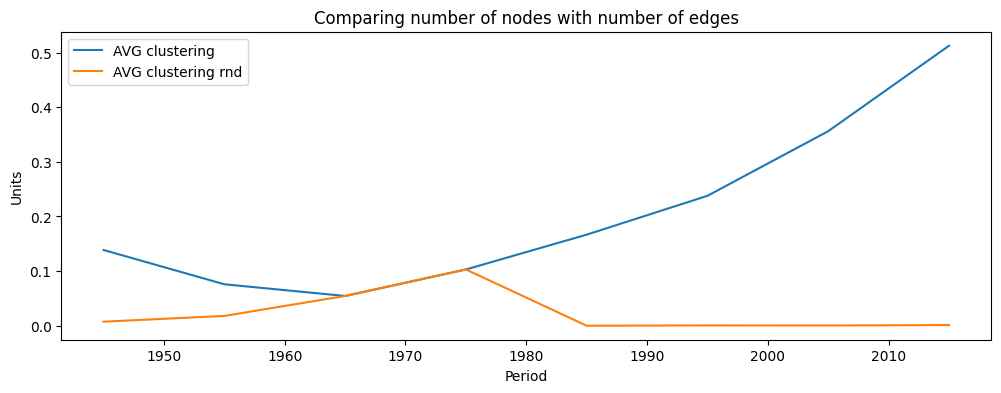

In [ ]:
df[["AVG clustering","AVG clustering rnd"]].set_index(temp).plot(figsize = (12, 4), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Comparing number of nodes with number of edges")

<Axes: title={'center': 'Considering distance in the Giant Component'}, xlabel='Period', ylabel='Units'>

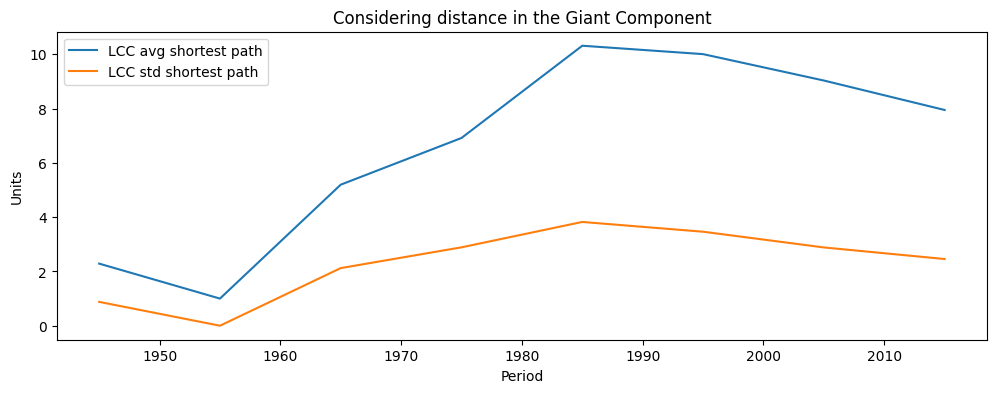

In [ ]:
df[["LCC avg shortest path", "LCC std shortest path"]].set_index(temp).plot(figsize = (12, 4), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Considering distance in the Giant Component")

1. number of nodes is very large compared to the average number of coauthors
2. the network is integrated; a giant component exists and covers a large share of the population
3. the average distance between nodes in the giant component is small: ie: the average distance is of order ln(n).
4. clustering is high such that the clustering coefficient is much larger than the average number of coauthors

In [ ]:
# # the ugliest donut shaped graphs ever.
# def plot_a_net(L, start, end):
#     plt.figure()
#     text="network graph of econ journal authors between "+str(start)+" and "+str(end)+" (exclusive). Nodes="+str(L.number_of_nodes())+". Edges="+str(L.number_of_edges())+'.'
#     plt.title(text)
#     nx.draw_spectral(L, with_labels=True, font_weight='light', node_size=5, font_size=5)
#     plt.show()